In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt

In [3]:
from estimator.estimator import neural_transfer_model
from utils.utils import get_image_tensor,deprocess_image

In [4]:
cols = 275
rows = 183

In [5]:
base_image = get_image_tensor("data/base.jpg",rows,cols)
style_image = get_image_tensor("data/style.jpg",rows,cols)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


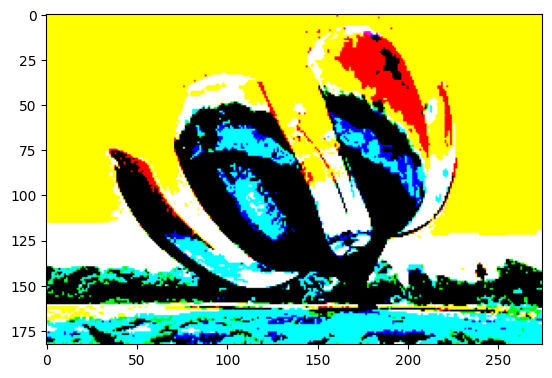

In [6]:
plt.imshow(base_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


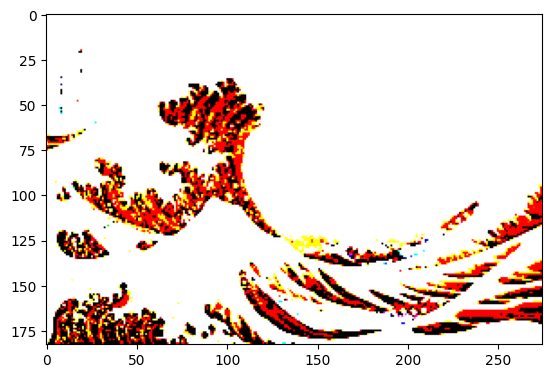

In [7]:
plt.imshow(style_image)

In [8]:
pre_trained_model = vgg19.VGG19(weights="imagenet", include_top=False)
for layer in pre_trained_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
content_layer = "block4_conv2"
style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]

In [10]:
model = neural_transfer_model(pre_trained_model = pre_trained_model,rows = rows,cols = cols,content_layers = content_layer,style_layers = style_layers,content_weight = 1e-2 ,style_weight = 1)

In [11]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001))

In [12]:
x_train = (np.expand_dims(base_image,axis = 0),np.expand_dims(style_image,axis = 0))

In [13]:
model.fit(x = x_train,epochs = 4000)

Epoch 1/4000
1/1 [==============================] - 8s 8s/step - total_loss: 68496117760.0000 - style_loss: 65981890560.0000 - content_loss: 251422851072.0000
Epoch 2/4000
1/1 [==============================] - 0s 36ms/step - total_loss: 68489134080.0000 - style_loss: 65977511936.0000 - content_loss: 251162427392.0000
Epoch 3/4000
1/1 [==============================] - 0s 33ms/step - total_loss: 68480262144.0000 - style_loss: 65972400128.0000 - content_loss: 250786086912.0000
Epoch 4/4000
1/1 [==============================] - 0s 34ms/step - total_loss: 68464472064.0000 - style_loss: 65965301760.0000 - content_loss: 249917194240.0000
Epoch 5/4000
1/1 [==============================] - 0s 34ms/step - total_loss: 68438663168.0000 - style_loss: 65955033088.0000 - content_loss: 248362909696.0000
Epoch 6/4000
1/1 [==============================] - 0s 34ms/step - total_loss: 68410208256.0000 - style_loss: 65942274048.0000 - content_loss: 246793437184.0000
Epoch 7/4000
1/1 [==================

In [14]:
result = deprocess_image(model.white_image[0].numpy(),rows,cols)

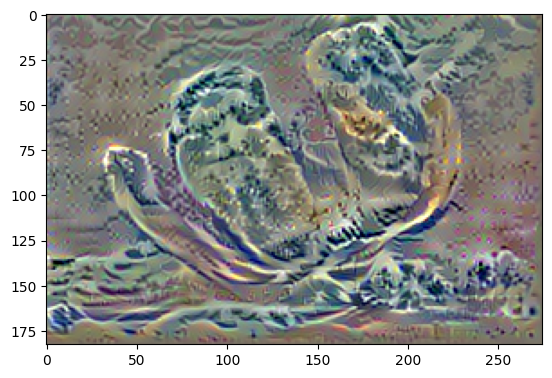

In [15]:
plt.imshow(result)